In [45]:
import pickle
import tensorflow
import numpy as np
from numpy.linalg import norm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
import cv2


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
feature_list = np.array(pickle.load(open('/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_FashioRecommendationSystem/new_embeddings.pkl','rb')))
filenames = pickle.load(open('/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_FashioRecommendationSystem/new_filenames.pkl','rb'))

In [48]:
print(feature_list.shape)

(11020, 2048)


We are suing a pretrained CCN model **ResNet** which is already on ImageNet which is already trained on more than million photos.

 we keep only the convolutional base of the model and remove the final fully connected layers because the **fully connected layers** need to be retrained for the new dataset, but the **convolutional layers** (which learn general features like edges, textures, and shapes) can still be useful.

However we are dropping the final layer of this model By setting include_top=False, so you can add your own layers suitable for your specific task

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, Input


input_tensor = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the base model; as we are not trraing our model, but using a transfer model and removing its top layers and modifying it on our data
base_model.trainable = False

# Add the GlobalMaxPooling2D layer on top of the base model as we have already droped the top_layer of Resnet for customistation based on our data
# The top layer is removed b/c it is  specific to the original task and add globalmax is good b/c adding GlobalMaxPooling2D as top ayer would
# effectively reduce the number of parameters and help avoid overfitting by aggregating the important features across the entire spatial dimension

x = base_model.output
x = GlobalMaxPooling2D()(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=x)

# Print the model summary
print(model.summary())

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [50]:
!pip install annoy


I use two techniques for recommendations;


*   **KNN** to compare the sample with all images to find the nearest neighbour.
*   **Annoy** technique which spotify use for its song recommendation



In [51]:
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex

# Initialize AnnoyIndex with the dimensionality of feature vectors
feature_dim = feature_list.shape[1]  # Assuming feature vectors are of same length
annoy_index = AnnoyIndex(feature_dim, metric='euclidean')

# Add all features to the Annoy index
for i, feature in enumerate(feature_list):
    annoy_index.add_item(i, feature)

# Build the index with 10 trees (you can adjust the number of trees for more accuracy vs speed)
annoy_index.build(10)

# you can chnage the name of the file add any file fro the sample tabd find its sample, his is content based recommendation
img = image.load_img('/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_FashioRecommendationSystem/sample/women_shirt.jpg',target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)
result = model.predict(preprocessed_img).flatten()
normalized_result = result / norm(result)

# neighbors = NearestNeighbors(n_neighbors=6,algorithm='brute',metric='euclidean')
# neighbors.fit(feature_list)
# distances,indices = neighbors.kneighbors([normalized_result])
# print(indices)

indices = annoy_index.get_nns_by_vector(normalized_result, 6, include_distances=True)
print(indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
([5191, 2362, 6241, 2350, 2323, 2431], [0.0, 0.4743891954421997, 0.5208094716072083, 0.5211907029151917, 0.523395299911499, 0.537346601486206])


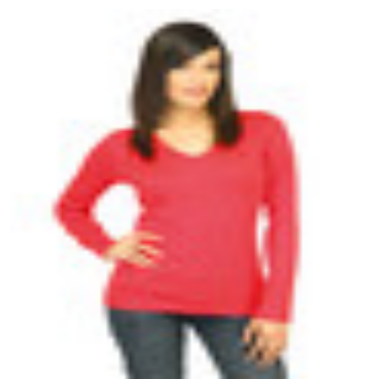

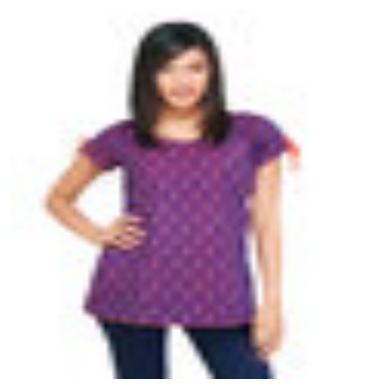

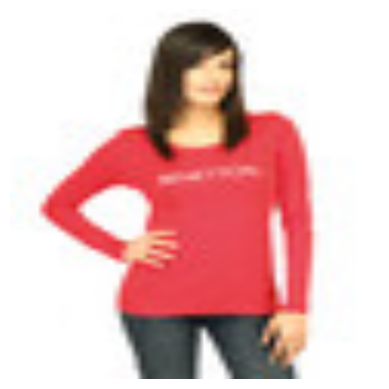

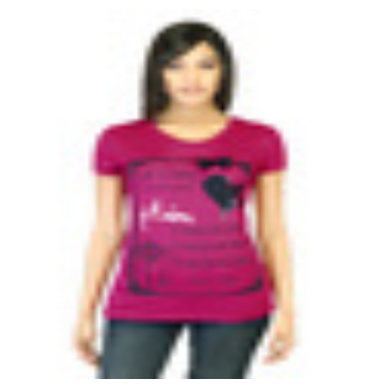

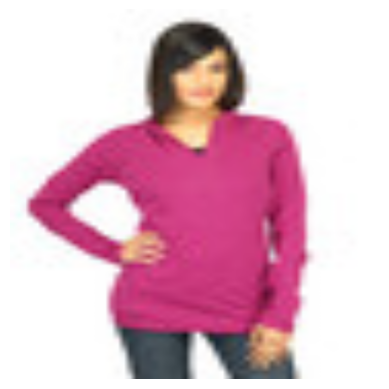

In [52]:
import matplotlib.pyplot as plt

for file in indices[0][1:6]:  # Skip the first, as it is the query image itself
    temp_img = cv2.imread(filenames[file])
    resized_img = cv2.resize(temp_img, (512, 512))

    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(rgb_img)
    plt.axis('off')  # Hide axes
    plt.show()





# This **Clustering** to images with similar features

In [53]:
def search_by_cluster(cluster_number, top_n=10):
    # Retrieve filenames that belong to the given cluster
    images_in_cluster = [filenames[i] for i in range(len(cluster_labels)) if cluster_labels[i] == cluster_number]

    # Limit to top N results
    top_images_in_cluster = images_in_cluster[:top_n]

    # Print the file paths of the top images in the cluster
    print(f"Found {len(top_images_in_cluster)} images in cluster {cluster_number}:")
    for img_path in top_images_in_cluster:
        print(img_path)  # Print image file path

    # Display the top images in the cluster
    for img_path in top_images_in_cluster:
        temp_img = cv2.imread(img_path)
        resized_img = cv2.resize(temp_img, (512, 512))
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
        plt.axis('off')
        plt.show()


Found 5 images in cluster 0:
/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_FashioRecommendationSystem/images/21528.jpg
/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_FashioRecommendationSystem/images/21552.jpg
/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_FashioRecommendationSystem/images/21540.jpg
/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_FashioRecommendationSystem/images/21541.jpg
/content/drive/My Drive/FatimaQurban_ML&DL_BytewiseFellowship2024/FatimaQurban_ML&DL_FashioRecommendationSystem/images/21526.jpg


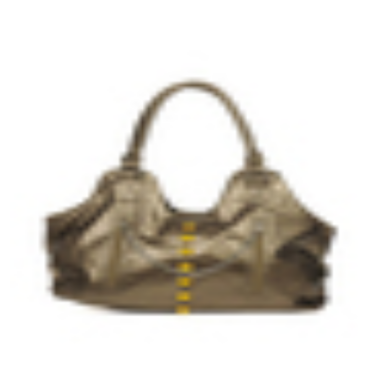

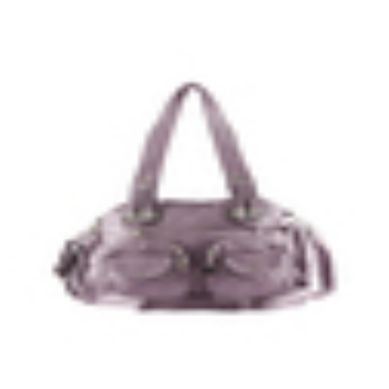

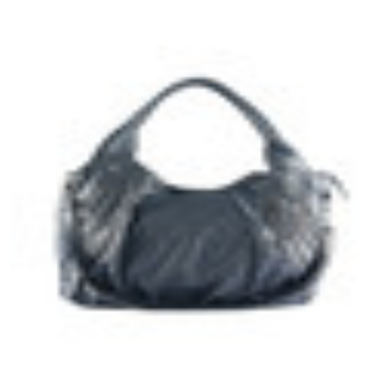

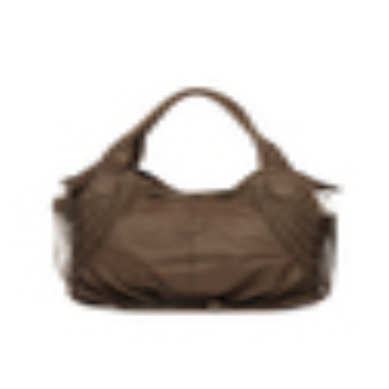

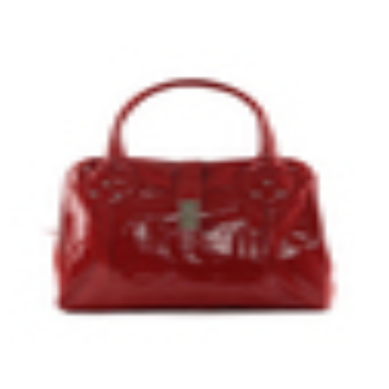

In [54]:
# # Search for top 10 images in cluster 0
search_by_cluster(0, top_n=5)

